In [17]:
import xarray as xr
import pandas as pd
import numpy as np
import tools.config as config
from tools.helper_plot import set_plot_style, draw_12_price, draw_10_price
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec



task_name = config.TASK_NAME
# task_name = '20250922_Paper2_Results_HPC_test'
input_dir = f'../../../output/{task_name}/carbon_price/1_draw_data'

In [42]:
def plot_two_series_ax(
    ax,
    df1,
    df2,
    color1="red",
    color2="blue",
    style1="o-",
    style2="s--",
    label1="Cost",
    label2="Biodiversity",
    title_name="",
    xlabel="Year",
    ylabel="Value"
):
    """
    在已有 ax 上绘制两个单列 DataFrame 的曲线，便于对比。

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        目标子图对象
    df1, df2 : pd.DataFrame
        单列 DataFrame，index 为年份
    color1, color2 : str
        曲线颜色
    style1, style2 : str
        线型
    label1, label2 : str
        图例标签
    title_name : str
        子图标题
    xlabel, ylabel : str
        坐标轴标签
    """

    # df1
    ax.plot(
        df1.index, df1.iloc[:, 0],
        style1, color=color1, label=label1,
        linewidth=2, markersize=5
    )

    # df2
    ax.plot(
        df2.index, df2.iloc[:, 0],
        style2, color=color2, label=label2,
        linewidth=2, markersize=5
    )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title_name, pad=6)

    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)
    
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.2)

    return ax


In [49]:
def draw_10_dfs(
    df1, df2,                 # 两个 DataFrame（每个都有 10 列，列名一致）
    title_map,
    color1="red", color2="blue",
    style1="o-", style2="s-",
    label1="Cost", label2="Biodiversity",
    output_path=None,
    y_lims=(-0.5, 0.5),
    ylabel=r"Carbon price for GHG and biodiversity (AU\$ tCO$_2$e$^{-1}$ yr$^{-1}$)",
    figsize=(24, 10),
    ylabel_pos=(-0.3, -0.2),  # (x, y) in axes coords
):
    """
    画两行共 10 张子图（df1/df2 的 10 列），每张对比两条曲线。
    依赖外部函数：plot_two_series_ax(ax, df1_col, df2_col, ...)
    """
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 5, figure=fig, hspace=0.5, wspace=0.2)

    # ---- 统一 x 轴刻度 ----
    x_data = df1.index
    x_min, x_max = x_data.min(), x_data.max()
    x_middle = x_data[int(len(x_data) // 2)]
    tick_positions = [x_min, x_middle, x_max]

    axes = []
    for i in range(10):
        row, col = divmod(i, 5)
        ax = fig.add_subplot(gs[row, col])

        # 单列 df
        df1_col = df1.iloc[:, i].to_frame()
        df2_col = df2.iloc[:, i].to_frame()

        plot_two_series_ax(
            ax,
            df1_col, df2_col,
            color1=color1, color2=color2,
            style1=style1, style2=style2,
            label1=label1 if i == 9 else "_nolegend_",   # 只有第一个子图显示图例
            label2=label2 if i == 9 else "_nolegend_",
            title_name=title_map.get(df1.columns[i], df1.columns[i]),
            xlabel="", ylabel=""
        )

        # 设置 y 轴范围
        ax.set_ylim(*y_lims)

        # 设置 x 轴刻度
        ax.set_xticks(tick_positions)

        # 只有第二行显示 x 轴标签
        if row == 1:
            ax.tick_params(axis='x', labelbottom=True)
        else:
            ax.tick_params(axis='x', labelbottom=False)

        # 左右对齐首尾 label
        x_labels = ax.get_xticklabels()
        if len(x_labels) >= 3:
            x_labels[0].set_horizontalalignment('left')
            x_labels[-1].set_horizontalalignment('right')

        # 非首列不显示 y 轴刻度文本
        if col != 0:
            ax.tick_params(axis='y', labelleft=False)

        axes.append(ax)

    # y 轴标签放在第一个子图上
    axes[0].set_ylabel(ylabel)
    axes[0].yaxis.set_label_coords(*ylabel_pos)

    if output_path:
        plt.savefig(output_path, dpi=300)
    plt.show()

    return fig, axes


In [44]:
cost_df = xr.open_dataarray(f'{input_dir}/xr_total_cost.nc').sum(dim='type').to_pandas().T
carbon_df = xr.open_dataarray(f'{input_dir}/xr_total_carbon.nc').sum(dim='type').to_pandas().T
bio_df = xr.open_dataarray(f'{input_dir}/xr_total_bio.nc').sum(dim='type').to_pandas().T

In [45]:
cost_growth =  np.log(cost_df).diff()
carbon_growth = np.log(carbon_df).diff()
bio_growth = np.log(bio_df).diff()

F:\xinhao\miniforge\envs\xpluto\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [46]:
df1 = cost_growth.iloc[:, -10:]
df1 = df1[df1.index >= config.START_YEAR] #config.START_YEAR
df2 = carbon_growth.iloc[:, -10:]
df2 = df2[df2.index >= config.START_YEAR]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

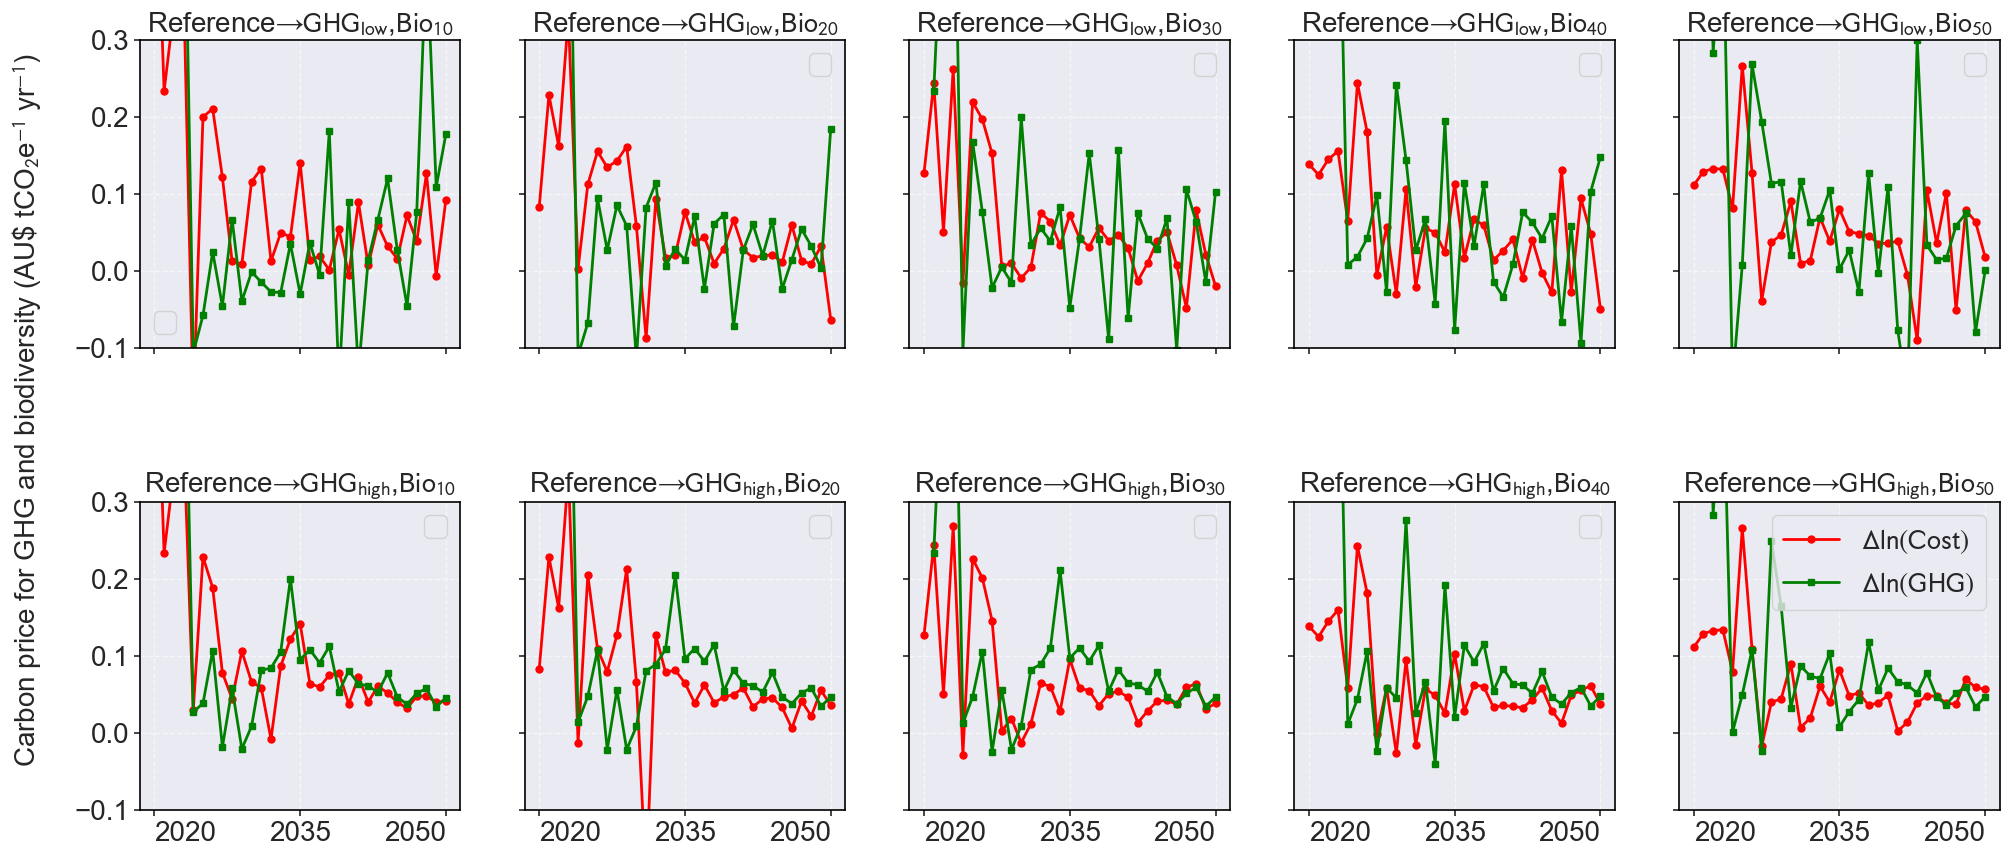

In [50]:
set_plot_style(20)
fig, axes = draw_10_dfs(
    df1, df2,
    config.PRICE_TITLE_MAP,
    color1="red", color2="green",y_lims=(-0.1,0.3),
    label1=r'$\Delta \ln(\mathrm{Cost})$', label2=r'$\Delta \ln(\mathrm{GHG})$',
    output_path="06_cost_benefit_compare.png"
)